In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image
from scipy.misc import imread

import tensorflow as tf

import os
print(os.listdir("./dataset"))

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Any results you write to the current directory are saved as output.

['train.csv', 'sample_submission.csv', 'protein-trainval-split', 'test', 'train']


In [2]:
train_labels = pd.read_csv("./dataset/train.csv")

In [3]:
label_names = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}

reverse_train_labels = dict((v,k) for k,v in label_names.items())

def fill_targets(row):
    row.Target = np.array(row.Target.split(" ")).astype(np.int)
    for num in row.Target:
        name = label_names[int(num)]
        row.loc[name] = 1
    return row

for key in label_names.keys():
    train_labels[label_names[key]] = 0
    
train_labels = train_labels.apply(fill_targets, axis=1)

In [4]:
print(train_labels.head())

                                     Id        Target  Nucleoplasm  \
0  00070df0-bbc3-11e8-b2bc-ac1f6b6435d0       [16, 0]            1   
1  000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  [7, 1, 2, 0]            1   
2  000a9596-bbc4-11e8-b2bc-ac1f6b6435d0           [5]            0   
3  000c99ba-bba4-11e8-b2b9-ac1f6b6435d0           [1]            0   
4  001838f8-bbca-11e8-b2bc-ac1f6b6435d0          [18]            0   

   Nuclear membrane  Nucleoli  Nucleoli fibrillar center  Nuclear speckles  \
0                 0         0                          0                 0   
1                 1         1                          0                 0   
2                 0         0                          0                 0   
3                 1         0                          0                 0   
4                 0         0                          0                 0   

   Nuclear bodies  Endoplasmic reticulum  Golgi apparatus      ...       \
0               0                  

In [5]:
train_path = "./dataset/train/"

## K fold cross validation

In [6]:
from os import listdir

train_files = listdir("./dataset/train")
test_files = listdir("./dataset/test")
percentage = np.round(len(test_files) / len(train_files) * 100)

print("The test set size turns out to be {} % compared to the train set.".format(percentage))

The test set size turns out to be 38.0 % compared to the train set.


In [7]:
from sklearn.model_selection import RepeatedKFold

splitter = RepeatedKFold(n_splits=3, n_repeats=2, random_state=0)

In [8]:
partitions = []

for train_idx, test_idx in splitter.split(train_labels.index.values):
    partition = {}
    partition["train"] = train_labels.Id.values[train_idx]
    partition["validation"] = train_labels.Id.values[test_idx]
    partitions.append(partition)
    print("TRAIN:", train_idx, "TEST:", test_idx)
    print("TRAIN:", len(train_idx), "TEST:", len(test_idx))

TRAIN: [    1     2     3 ... 31063 31064 31065] TEST: [    0     4     6 ... 31069 31070 31071]
TRAIN: 20714 TEST: 10358
TRAIN: [    0     4     6 ... 31069 31070 31071] TEST: [    1     2     3 ... 31060 31061 31065]
TRAIN: 20715 TEST: 10357
TRAIN: [    0     1     2 ... 31069 31070 31071] TEST: [   10    11    13 ... 31062 31063 31064]
TRAIN: 20715 TEST: 10357
TRAIN: [    0     1     3 ... 31068 31070 31071] TEST: [    2     8    10 ... 31064 31067 31069]
TRAIN: 20714 TEST: 10358
TRAIN: [    2     4     7 ... 31067 31069 31070] TEST: [    0     1     3 ... 31066 31068 31071]
TRAIN: 20715 TEST: 10357
TRAIN: [    0     1     2 ... 31068 31069 31071] TEST: [    4     7     9 ... 31061 31065 31070]
TRAIN: 20715 TEST: 10357


In [9]:
print(partitions)

[{'train': array(['000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0',
       '000a9596-bbc4-11e8-b2bc-ac1f6b6435d0',
       '000c99ba-bba4-11e8-b2b9-ac1f6b6435d0', ...,
       'ffe55eba-bbba-11e8-b2ba-ac1f6b6435d0',
       'ffe61798-bbc3-11e8-b2bc-ac1f6b6435d0',
       'ffe8cf0c-bba9-11e8-b2ba-ac1f6b6435d0'], dtype=object), 'validation': array(['00070df0-bbc3-11e8-b2bc-ac1f6b6435d0',
       '001838f8-bbca-11e8-b2bc-ac1f6b6435d0',
       '0020af02-bbba-11e8-b2ba-ac1f6b6435d0', ...,
       'fff189d8-bbab-11e8-b2ba-ac1f6b6435d0',
       'fffdf7e0-bbc4-11e8-b2bc-ac1f6b6435d0',
       'fffe0ffe-bbc0-11e8-b2bb-ac1f6b6435d0'], dtype=object)}, {'train': array(['00070df0-bbc3-11e8-b2bc-ac1f6b6435d0',
       '001838f8-bbca-11e8-b2bc-ac1f6b6435d0',
       '0020af02-bbba-11e8-b2ba-ac1f6b6435d0', ...,
       'fff189d8-bbab-11e8-b2ba-ac1f6b6435d0',
       'fffdf7e0-bbc4-11e8-b2bc-ac1f6b6435d0',
       'fffe0ffe-bbc0-11e8-b2bb-ac1f6b6435d0'], dtype=object), 'validation': array(['000a6c98-bb9b-11e8-b2b9-ac1f6b643

In [10]:
class ImagePreprocessor:
    
    def __init__(self, modelparameter):
        self.parameter = modelparameter
        self.basepath = self.parameter.basepath
        self.scaled_row_dim = self.parameter.scaled_row_dim
        self.scaled_col_dim = self.parameter.scaled_col_dim
        self.n_channels = self.parameter.n_channels
    
    def preprocess(self, image_id):
        image = self.load_image(image_id)
#         image = self.reshape(image)
        image = self.resize(image)
        image = self.normalize(image)
        return image
    
    def resize(self, image):
        image = resize(image, (self.scaled_row_dim, self.scaled_col_dim))
        return image
    
    def reshape(self, image):
        image = np.rollaxis(image, 0,3)
        return image
    
    def normalize(self, image):
        image /= 255 
        return image
    
    def load_image(self, image_id):
        image = np.zeros(shape=(512,512,4))
        image[:,:,0] = imread(self.basepath + image_id + "_green" + ".png")
        image[:,:,1] = imread(self.basepath + image_id + "_blue" + ".png")
        image[:,:,2] = imread(self.basepath + image_id + "_red" + ".png")
        image[:,:,3] = imread(self.basepath + image_id + "_yellow" + ".png")
        return image[:,:,0:self.parameter.n_channels]

In [11]:
from skimage.transform import resize

def load_image(basepath, image_id, modelparameters):
    images = np.zeros(shape=(4,512,512))
    images[0,:,:] = imread(basepath + image_id + "_green" + ".png")
    images[1,:,:] = imread(basepath + image_id + "_red" + ".png")
    images[2,:,:] = imread(basepath + image_id + "_blue" + ".png")
    images[3,:,:] = imread(basepath + image_id + "_yellow" + ".png")
    
    images = np.rollaxis(images, 0,3)
    
    images = resize(images,(modelparameters.scaled_row_dim, modelparameters.scaled_col_dim))
    
    return images

In [22]:
class ModelParameter:
    
    def __init__(self, basepath,
                 num_classes=28,
                 image_rows=512,
                 image_cols=512,
                 batch_size=200,
                 n_channels=1,
                 row_scale_factor=1,
                 col_scale_factor=1,
                 shuffle=False,
                 n_epochs=1):
        self.basepath = basepath
        self.num_classes = num_classes
        self.image_rows = image_rows
        self.image_cols = image_cols
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.row_scale_factor = row_scale_factor
        self.col_scale_factor = col_scale_factor
        self.scaled_row_dim = np.int(self.image_rows / self.row_scale_factor)
        self.scaled_col_dim = np.int(self.image_cols / self.col_scale_factor)
        self.n_epochs = n_epochs

In [27]:
parameter = ModelParameter(train_path, batch_size=256, n_channels=3, n_epochs=5)
preprocessor = ImagePreprocessor(parameter)

(512, 512, 3)


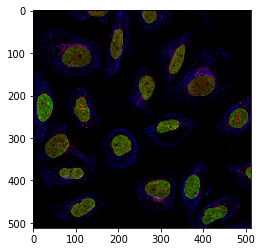

In [28]:
image = preprocessor.preprocess(partitions[0]["train"][0])
print(image.shape)
plt.imshow(image)
plt.show()

In [29]:
import keras

class DataGenerator(keras.utils.Sequence):
    
    def __init__(self, list_IDs, labels, modelparameter, imagepreprocessor):
        self.current_epoch = 0
        self.params = modelparameter
        self.labels = labels
        self.list_IDs = list_IDs
        self.dim = (self.params.scaled_row_dim, self.params.scaled_col_dim)
        self.batch_size = self.params.batch_size
        self.n_channels = self.params.n_channels
        self.num_classes = self.params.num_classes
        self.shuffle = self.params.shuffle
        self.preprocessor = imagepreprocessor
        self.on_epoch_end()
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def get_targets_per_image(self, identifier):
        return self.labels.loc[self.labels.Id==identifier].drop(["Id", "Target"], axis=1).values
    
    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        Y = np.empty((self.batch_size, self.num_classes), dtype=int)
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = self.preprocessor.preprocess(ID)
            # Store class
            Y[i] = self.get_targets_per_image(ID)            
        return X, Y

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

In [30]:
class PredictGenerator:
    
    def __init__(self, predict_Ids, imagepreprocessor, predict_path):
        self.preprocessor = imagepreprocessor
        self.preprocessor.basepath = predict_path
        self.identifiers = predict_Ids
    
    def predict(self, model):
        y = np.empty(shape=(len(self.identifiers), self.preprocessor.parameter.num_classes))
        for n in range(len(self.identifiers)):
            image = self.preprocessor.preprocess(self.identifiers[n])
            image = image.reshape((1, *image.shape))
            y[n] = model.predict(image)
        return y

## CNN Baseline Model using Keras

In [31]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.losses import binary_crossentropy
from keras.optimizers import Adadelta
from keras.initializers import VarianceScaling
from keras.utils import multi_gpu_model

class BaseLineModel:
    
    def __init__(self, modelparameter):
        self.params = modelparameter
        self.num_classes = self.params.num_classes
        self.img_rows = self.params.scaled_row_dim
        self.img_cols = self.params.scaled_col_dim
        self.n_channels = self.params.n_channels
        self.input_shape = (self.img_rows, self.img_cols, self.n_channels)
        self.my_metrics = ['accuracy']
    
    def build_model(self):
        self.model = Sequential()
        self.model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=self.input_shape,
                             kernel_initializer=VarianceScaling(seed=0)))
        self.model.add(Conv2D(32, (3, 3), activation='relu',
                             kernel_initializer=VarianceScaling(seed=0)))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        self.model.add(Dropout(0.25))
        self.model.add(Flatten())
        self.model.add(Dense(64, activation='relu',
                            kernel_initializer=VarianceScaling(seed=0),))
        self.model.add(Dropout(0.5))
        self.model.add(Dense(self.num_classes, activation='sigmoid'))
#         self.model = multi_gpu_model(self.model, gpus=2)
    
    def compile_model(self):
        self.model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=self.my_metrics)
    
    def set_generators(self, train_generator, validation_generator):
        self.training_generator = train_generator
        self.validation_generator = validation_generator
    
    def learn(self):
        return self.model.fit_generator(generator=self.training_generator,
                    validation_data=self.validation_generator,
                    epochs=self.params.n_epochs, 
                    use_multiprocessing=True,
                    workers=8)
    
    def score(self):
        return self.model.evaluate_generator(generator=self.validation_generator,
                                      use_multiprocessing=True, 
                                      workers=8)
    
    def predict(self, predict_generator):
        y = predict_generator.predict(self.model)
        return y
    
    def save(self, modeloutputpath):
        self.model.save(modeloutputpath)
    
    def load(self, modelinputpath):
        self.model = load_model(modelinputpath)

In [32]:
class TrainModel:
    def __init__(self, parameter, partitions, train_labels, train_path, preprocessor):
        self.parameter = parameter
        self.partitions = partitions
        self.train_path = train_path
        self.labels = train_labels
        self.preprocessor = preprocessor
        self.target_names = train_labels.drop(["Target", "Id"], axis=1).columns
        self.model = BaseLineModel(parameter)
        self.model.build_model()
        self.model.compile_model()
        
    def train(self):
        self.predictions = []
        for i, partition in enumerate(partitions):
            print("training in partition ",i+1)
            training_generator = DataGenerator(partition['train'], self.labels, self.parameter, self.preprocessor)
            validation_generator = DataGenerator(partition['validation'], self.labels, self.parameter, self.preprocessor)
            predict_generator = PredictGenerator(partition['validation'], self.preprocessor, self.train_path)
            self.model.set_generators(training_generator, validation_generator)
            history = self.model.learn()

            proba_predictions = self.model.predict(predict_generator)
            baseline_proba_predictions = pd.DataFrame(index = partition['validation'],
                                                      data=proba_predictions,
                                                      columns=self.target_names)
            self.predictions.append(baseline_proba_predictions)
            baseline_losses = pd.DataFrame(history.history["loss"], columns=["train_loss"])
            baseline_losses["val_loss"] = history.history["val_loss"]
            baseline_losses.to_csv("baseline_losses"+str(i)+".csv")

In [33]:
trainmodel = TrainModel(parameter, partitions, train_labels, train_path, preprocessor)

In [34]:
print(trainmodel.model.model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 510, 510, 16)      448       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 508, 508, 32)      4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 254, 254, 32)      0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 254, 254, 32)      0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2064512)           0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                132128832 
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
__________

In [18]:
config = tf.ConfigProto(
        device_count = {'GPU': 0}
    )
sess = tf.Session(config=config)
from keras import backend as K
K.set_session(sess)

In [19]:
trainmodel.train()

training in partition  1
Epoch 1/5
18/80 [=====>........................] - ETA: 12:35 - loss: 5.2295 - acc: 0.1417

Process ForkPoolWorker-7:
Process ForkPoolWorker-14:
Process ForkPoolWorker-15:
Process ForkPoolWorker-10:
Process ForkPoolWorker-8:
Process ForkPoolWorker-16:
Process ForkPoolWorker-1:
Process ForkPoolWorker-2:
Process ForkPoolWorker-6:
Process ForkPoolWorker-11:
Process ForkPoolWorker-13:
Process ForkPoolWorker-3:
Process ForkPoolWorker-12:
Process ForkPoolWorker-9:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/anaconda3/envs/py36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/opt/anaconda3/envs/py36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/anaconda3/envs/py36/lib/python3.6/mu

  File "/opt/anaconda3/envs/py36/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/opt/anaconda3/envs/py36/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/opt/anaconda3/envs/py36/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/opt/anaconda3/envs/py36/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/opt/anaconda3/envs/py36/lib/python3.6/site-packages/keras/utils/data_utils.py", line 401, in get_index
    return _SHARED_SEQUENCES[uid][i]
KeyboardInterrupt
  File "/opt/anaconda3/envs/py36/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "<ipython-input-13-7192ddf23a00>", line 35, in __data_generation
    X[i,] = self.preprocessor.preprocess(ID)
  File "/opt/anaconda3/envs/py36/lib/python3.6/multiprocessin

  File "/opt/anaconda3/envs/py36/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/opt/anaconda3/envs/py36/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/opt/anaconda3/envs/py36/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/opt/anaconda3/envs/py36/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/opt/anaconda3/envs/py36/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/opt/anaconda3/envs/py36/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/opt/anaconda3/envs/py36/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/opt/anaconda3/envs/py36/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/opt/anaconda3/envs/py36/lib/python3.6/multiprocessing/synchronize.py", line 95, in __en

KeyboardInterrupt: 

In [27]:
predictions = trainmodel.predictions

In [24]:
trainmodel.model.save("baselinemodel1.h5")

In [25]:
import keras.backend as K

def base_f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return f1

def f1_min(y_true, y_pred):
    f1 = base_f1(y_true, y_pred)
    return K.min(f1)

def f1_max(y_true, y_pred):
    f1 = base_f1(y_true, y_pred)
    return K.max(f1)

def f1_mean(y_true, y_pred):
    f1 = base_f1(y_true, y_pred)
    return K.mean(f1)

def f1_std(y_true, y_pred):
    f1 = base_f1(y_true, y_pred)
    return K.std(f1)

In [28]:
for partition,prediction in zip(partitions,predictions):
    validation_labels = train_labels.loc[train_labels.Id.isin(partition["validation"])].copy()
    y_true = validation_labels.drop(["Id", "Target"], axis=1).values
    y_pred = np.where(prediction.values > 0.5, 1, 0)
    
    with tf.Session() as sess:
        print(sess.run(base_f1(y_true.flatten(), y_pred.flatten())))
    

0.35719544
0.41940627
0.47700006
0.5152696
0.612444
0.65134656


In [1]:
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Dense, Dropout, Flatten
from keras.layers import MaxPooling2D
from keras.losses import binary_crossentropy
from keras.optimizers import Adadelta
from keras.initializers import VarianceScaling


class InceModel:
    
    def __init__(self, modelparameter):
        self.params = modelparameter
        self.num_classes = self.params.num_classes
        self.img_rows = self.params.scaled_row_dim
        self.img_cols = self.params.scaled_col_dim
        self.n_channels = self.params.n_channels
        self.input_shape = (self.img_rows, self.img_cols, self.n_channels)
        self.my_metrics = ['accuracy']
    
    def build_model(self):
        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(self.params.scaled_row_dim, self.params.scaled_col_dim, self.params.n_channels))
        x = base_model.output
        x = MaxPooling2D()(x)
        x = Dropout(0.25)(x)
        x = Flatten()(x)
        x = Dense(64, activation='relu', kernel_initializer=VarianceScaling(seed=0),)(x)
        x = Dropout(0.5)(x)
        predictions = Dense(self.num_classes, activation='sigmoid')(x)
        
        self.model = Model(inputs=base_model.input, outputs=predictions)
        
        for layer in base_model.layers:
            layer.trainable = False
    
    def compile_model(self):
        self.model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=self.my_metrics)
    
    def set_generators(self, train_generator, validation_generator):
        self.training_generator = train_generator
        self.validation_generator = validation_generator
    
    def learn(self):
        return self.model.fit_generator(generator=self.training_generator,
                    validation_data=self.validation_generator,
                    epochs=self.params.n_epochs, 
                    use_multiprocessing=True,
                    workers=8)
    
    def score(self):
        return self.model.evaluate_generator(generator=self.validation_generator,
                                      use_multiprocessing=True, 
                                      workers=8)
    
    def predict(self, predict_generator):
        y = predict_generator.predict(self.model)
        return y
    
    def save(self, modeloutputpath):
        self.model.save(modeloutputpath)
    
    def load(self, modelinputpath):
        self.model = load_model(modelinputpath)

Using TensorFlow backend.


In [80]:
class ModelWrapper:
    def __init__(self, modelObj, partitions, train_labels, preprocessor):
        self.model = modelObj
        self.parameter = modelObj.params
        self.partitions = partitions
        self.train_path = self.parameter.basepath
        self.labels = train_labels
        self.preprocessor = preprocessor
        self.target_names = train_labels.drop(["Target", "Id"], axis=1).columns
        
    def train(self):
        self.predictions = []
        for i, partition in enumerate(partitions):
            print("training in partition ",i+1)
            training_generator = DataGenerator(partition['train'], self.labels, self.parameter, self.preprocessor)
            validation_generator = DataGenerator(partition['validation'], self.labels, self.parameter, self.preprocessor)
            predict_generator = PredictGenerator(partition['validation'], self.preprocessor, self.train_path)
            self.model.set_generators(training_generator, validation_generator)
            history = self.model.learn()

            proba_predictions = self.model.predict(predict_generator)
            baseline_proba_predictions = pd.DataFrame(index = partition['validation'],
                                                      data=proba_predictions,
                                                      columns=self.target_names)
            self.predictions.append(baseline_proba_predictions)
            baseline_losses = pd.DataFrame(history.history["loss"], columns=["train_loss"])
            baseline_losses["val_loss"] = history.history["val_loss"]
            baseline_losses.to_csv("baseline_losses"+str(i)+".csv")
            
    def scores(self):
        self.f1_scores = []
        with tf.Session() as sess:
            for partition,prediction in zip(self.partitions,self.predictions):
                validation_labels = train_labels.loc[train_labels.Id.isin(partition["validation"])].copy()
                y_true = validation_labels.drop(["Id", "Target"], axis=1).values
                y_pred = np.where(prediction.values > 0.5, 1, 0)
                self.f1_scores.append(sess.run(base_f1(y_true.flatten(), y_pred.flatten())))
        return self.f1_scores
    
    def save_model(self,path):
        self.model.save(path)

In [2]:
incParameter = ModelParameter(train_path, batch_size=200, n_channels=3, n_epochs=2)
incPreprocessor = ImagePreprocessor(incParameter)

NameError: name 'ModelParameter' is not defined

In [73]:
inceptionModel = InceModel(incParameter)
inceptionModel.build_model()
inceptionModel.compile_model()

In [84]:
modWrap = ModelWrapper(inceptionModel, partitions, train_labels, incPreprocessor)

(128, 128, 3)


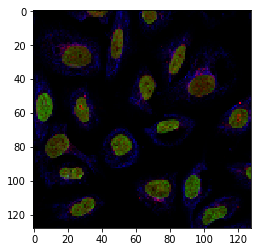

In [85]:
image = incPreprocessor.preprocess(partitions[0]["train"][0])
print(image.shape)
plt.imshow(image)
plt.show()

In [86]:
modWrap.train()

training in partition  1
Epoch 1/2
102/103 [============================>.] - ETA: 1s - loss: 4.7095 - acc: 0.3157Epoch 1/2
Epoch 1/2
103/103 [==============================] - 314s 3s/step - loss: 4.7061 - acc: 0.3165 - val_loss: 4.9083 - val_acc: 0.4185
Epoch 2/2
103/103 [==============================] - 280s 3s/step - loss: 4.3976 - acc: 0.3715 - val_loss: 4.7321 - val_acc: 0.4185
training in partition  2
Epoch 1/2
103/103 [==============================] - 277s 3s/step - loss: 4.3362 - acc: 0.4044 - val_loss: 4.7150 - val_acc: 0.4130
Epoch 2/2
103/103 [==============================] - 279s 3s/step - loss: 4.2929 - acc: 0.4127 - val_loss: 4.7726 - val_acc: 0.4130
training in partition  3
Epoch 1/2
103/103 [==============================] - 282s 3s/step - loss: 4.2748 - acc: 0.4150 - val_loss: 5.0756 - val_acc: 0.4123
Epoch 2/2
103/103 [==============================] - 257s 2s/step - loss: 4.2417 - acc: 0.4157 - val_loss: 4.7973 - val_acc: 0.4123
training in partition  4
Epoch 1/2

In [87]:
print(modWrap.scores())

[0.35984024, 0.37395075, 0.3569803, 0.3527103, 0.33049205, 0.3392444]


In [89]:
modWrap.save_model("ince.h5")

In [94]:
parameter = ModelParameter(train_path, batch_size=200, n_channels=4, n_epochs=5, row_scale_factor=1, col_scale_factor=1)
preprocessor = ImagePreprocessor(parameter)

(512, 512, 4)


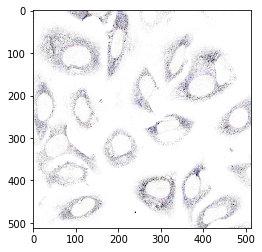

In [95]:
image = preprocessor.preprocess(partitions[0]["train"][0])
print(image.shape)
plt.imshow(image)
plt.show()